# Forecast for Energy Mix

## 1.Setup

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install skforecast
# !pip install scikit-learn==1.2
# !pip install pycaret

clear_output()

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
import pandas as pd
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

In [ ]:
google_drive_path = "/content/drive/MyDrive/LINC/"

In [ ]:
columns_list = [
    "time", "temperature_2m_c", "relative_humidity_2m_percent", "dew_point_2m_c", "apparent_temperature_c",
    "precipitation_mm", "rain_mm", "snowfall_cm", "weather_code_wmo_code", "pressure_msl_h_pa",
    "surface_pressure_h_pa", "cloud_cover_percent", "cloud_cover_low_percent", "cloud_cover_mid_percent",
    "cloud_cover_high_percent", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_k_pa",
    "wind_speed_10m_km_h", "wind_direction_10m", "wind_gusts_10m_km_h"
]

## 2.Get historical weather data

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
def get_cy_wind_historical(lati, longi, suffix):

  url = "https://archive-api.open-meteo.com/v1/archive"

  params = {
	  "latitude": lati,
	  "longitude": longi,
	  "start_date": "2023-01-01",
	  "end_date": "2024-05-30",
	  "hourly": ["wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
	  "timezone": "Europe/Moscow"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_gusts_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
	  start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	  end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	  freq = pd.Timedelta(seconds = hourly.Interval()),
	  inclusive = "left"
  )}

  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
  hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_convert('Europe/Athens')

  # Adding suffix to columns 2 to 4
  for col in hourly_dataframe.columns[1:]:  # Columns 2 to end
    hourly_dataframe.rename(columns={col: col + suffix}, inplace=True)

  return hourly_dataframe
  # hourly_dataframe

In [ ]:
def get_cy_temp_historical(lati, longi, suffix):

  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
	  "latitude": lati,
	  "longitude": longi,
	  "start_date": "2023-01-01",
	  "end_date": "2024-05-30",
	  "hourly": ["apparent_temperature", "shortwave_radiation", "direct_radiation", "diffuse_radiation",
              "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation"],
	  "timezone": "Europe/Moscow",
	  "tilt": 17,
	  "azimuth": -39
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_apparent_temperature = hourly.Variables(0).ValuesAsNumpy()
  hourly_shortwave_radiation = hourly.Variables(1).ValuesAsNumpy()
  hourly_direct_radiation = hourly.Variables(2).ValuesAsNumpy()
  hourly_diffuse_radiation = hourly.Variables(3).ValuesAsNumpy()
  hourly_direct_normal_irradiance = hourly.Variables(4).ValuesAsNumpy()
  hourly_global_tilted_irradiance = hourly.Variables(5).ValuesAsNumpy()
  hourly_terrestrial_radiation = hourly.Variables(6).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
	  start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	  end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	  freq = pd.Timedelta(seconds = hourly.Interval()),
	  inclusive = "left"
  )}

  hourly_data["apparent_temperature"] = hourly_apparent_temperature
  hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
  hourly_data["direct_radiation"] = hourly_direct_radiation
  hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
  hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
  hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance
  hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_convert('Europe/Athens')

  # Adding suffix to columns 2 to 4
  for col in hourly_dataframe.columns[1:]:  # Columns 2 to end
    hourly_dataframe.rename(columns={col: col + suffix}, inplace=True)

  return hourly_dataframe


In [ ]:
get_cy_temp_historical(35.19, 33.38, "_nic").columns

Index(['date', 'apparent_temperature_nic', 'shortwave_radiation_nic',
       'direct_radiation_nic', 'diffuse_radiation_nic',
       'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic',
       'terrestrial_radiation_nic'],
      dtype='object')

In [ ]:
# Alexigiros windfarm -> https://www.thewindpower.net/windfarm_en_15412_alexigros.php
df_ag = get_cy_wind_historical(34.8694, 33.5168, '_ag')
# Ayia Anna -> https://www.thewindpower.net/windfarm_en_15926_ayia-anna.php
df_aa = get_cy_wind_historical(34.9609, 33.4916, '_aa')
# Orites windfarm -> https://www.thewindpower.net/windfarm_en_17098_orites.php
df_or = get_cy_wind_historical(34.7394, 32.6574, "_or")
# Nicosia apparent temperature
df_nic = get_cy_temp_historical(35.19, 33.38, "_nic") # nicosia temperature

df_weather_historical = df_ag.merge(df_aa, on='date', how='inner').merge(df_or, on='date', how='inner').merge(df_nic, on='date', how='inner')

df_weather_historical#.dtypes

,date,wind_speed_10m_ag,wind_direction_10m_ag,wind_gusts_10m_ag,wind_speed_10m_aa,wind_direction_10m_aa,wind_gusts_10m_aa,wind_speed_10m_or,wind_direction_10m_or,wind_gusts_10m_or,apparent_temperature_nic,shortwave_radiation_nic,direct_radiation_nic,diffuse_radiation_nic,direct_normal_irradiance_nic,global_tilted_irradiance_nic,terrestrial_radiation_nic
0,2022-12-31 23:00:00+02:00,11.384198,325.304779,22.680000,9.000000,306.869965,15.480000,10.799999,360.000000,20.880001,7.282764,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2023-01-01 00:00:00+02:00,11.792404,328.736328,23.400000,9.957108,319.398773,17.280001,11.966953,6.911131,23.400000,8.533049,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2023-01-01 01:00:00+02:00,12.413477,330.461304,25.559999,9.504272,322.695953,18.000000,11.013882,11.309896,23.759998,7.727057,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2023-01-01 02:00:00+02:00,13.089354,328.495789,24.840000,9.673221,315.000092,16.559999,7.993298,7.765082,21.599998,7.965912,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2023-01-01 03:00:00+02:00,12.240000,331.927612,26.280001,9.178235,318.179901,17.280001,9.779817,6.340100,18.719999,6.463960,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12379,2024-05-30 19:00:00+03:00,2.968636,345.963715,13.320000,7.421590,337.166290,15.840000,16.179985,290.854523,37.799999,23.059320,167.0,84.0,83.0,321.463501,87.539574,347.788971
12380,2024-05-30 20:00:00+03:00,10.661107,348.310669,19.440001,14.277983,326.309906,25.559999,13.849477,297.897186,34.560001,22.036884,32.0,10.0,22.0,85.195602,21.659176,97.454674
12381,2024-05-30 21:00:00+03:00,12.558790,332.700500,23.759998,17.317459,316.684631,32.399998,11.753876,319.969788,28.799999,20.890568,0.0,0.0,0.0,0.000000,0.000000,0.000000
12382,2024-05-30 22:00:00+03:00,11.753876,319.969788,23.759998,17.610588,310.855286,33.119999,10.630672,331.699341,24.480000,20.565252,0.0,0.0,0.0,0.000000,0.000000,0.000000


## 3.Combing with historical energy mix data

In [ ]:
df_EnMix_historical = pd.read_csv(google_drive_path + "EnergyMix_CY_historical_estimated_01-06-2022_30-05-2024.csv")# "EnergyMix_CY_historical_estimated_01-01-2022_18-06-2024.csv")
df_EnMix_historical = df_EnMix_historical.dropna().reset_index(drop=True)
df_EnMix_historical['timestamp'] = pd.to_datetime(df_EnMix_historical['timestamp'], utc = True).dt.tz_convert('Europe/Athens')

In [ ]:
df_weather_historical.columns, df_EnMix_historical.columns

(Index(['date', 'wind_speed_10m_ag', 'wind_direction_10m_ag',
        'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
        'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or',
        'wind_gusts_10m_or', 'apparent_temperature_nic',
        'shortwave_radiation_nic', 'direct_radiation_nic',
        'diffuse_radiation_nic', 'direct_normal_irradiance_nic',
        'global_tilted_irradiance_nic', 'terrestrial_radiation_nic'],
       dtype='object'),
 Index(['timestamp', 'total', 'wind', 'oil', 'gas', 'coal', 'biomass', 'pv',
        'water'],
       dtype='object'))

In [ ]:
df_all = pd.merge(df_weather_historical, df_EnMix_historical, how='left', left_on='date', right_on='timestamp').drop(columns = ['timestamp'])
df_all[['date', 'total', 'wind', 'oil', 'gas', 'coal', 'biomass', 'pv', 'water']] = \
df_all[['date', 'total', 'wind', 'oil', 'gas', 'coal', 'biomass', 'pv', 'water']].fillna(method='ffill')

In [ ]:
df_all

,date,wind_speed_10m_ag,wind_direction_10m_ag,wind_gusts_10m_ag,wind_speed_10m_aa,wind_direction_10m_aa,wind_gusts_10m_aa,wind_speed_10m_or,wind_direction_10m_or,wind_gusts_10m_or,...,global_tilted_irradiance_nic,terrestrial_radiation_nic,total,wind,oil,gas,coal,biomass,pv,water
0,2022-12-31 23:00:00+02:00,11.384198,325.304779,22.680000,9.000000,306.869965,15.480000,10.799999,360.000000,20.880001,...,0.000000,0.000000,517.0,26.0,485.0,0.0,0.0,6.0,0.0,0.0
1,2023-01-01 00:00:00+02:00,11.792404,328.736328,23.400000,9.957108,319.398773,17.280001,11.966953,6.911131,23.400000,...,0.000000,0.000000,496.0,34.0,455.0,0.0,0.0,6.0,0.0,0.0
2,2023-01-01 01:00:00+02:00,12.413477,330.461304,25.559999,9.504272,322.695953,18.000000,11.013882,11.309896,23.759998,...,0.000000,0.000000,476.0,36.0,434.0,0.0,0.0,6.0,0.0,0.0
3,2023-01-01 02:00:00+02:00,13.089354,328.495789,24.840000,9.673221,315.000092,16.559999,7.993298,7.765082,21.599998,...,0.000000,0.000000,451.0,36.0,408.0,0.0,0.0,6.0,0.0,0.0
4,2023-01-01 03:00:00+02:00,12.240000,331.927612,26.280001,9.178235,318.179901,17.280001,9.779817,6.340100,18.719999,...,0.000000,0.000000,413.0,33.0,374.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12379,2024-05-30 19:00:00+03:00,2.968636,345.963715,13.320000,7.421590,337.166290,15.840000,16.179985,290.854523,37.799999,...,87.539574,347.788971,621.0,48.0,530.0,0.0,0.0,6.0,36.0,0.0
12380,2024-05-30 20:00:00+03:00,10.661107,348.310669,19.440001,14.277983,326.309906,25.559999,13.849477,297.897186,34.560001,...,21.659176,97.454674,618.0,60.0,549.0,0.0,0.0,6.0,3.0,0.0
12381,2024-05-30 21:00:00+03:00,12.558790,332.700500,23.759998,17.317459,316.684631,32.399998,11.753876,319.969788,28.799999,...,0.000000,0.000000,620.0,53.0,558.0,0.0,0.0,6.0,3.0,0.0
12382,2024-05-30 22:00:00+03:00,11.753876,319.969788,23.759998,17.610588,310.855286,33.119999,10.630672,331.699341,24.480000,...,0.000000,0.000000,573.0,52.0,512.0,0.0,0.0,6.0,3.0,0.0


## 4.Wind Model

In [ ]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math

In [ ]:
# Backtesting with custom metric
# ==============================================================================
def custom_mape(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    return np.mean(mape)

In [ ]:
# Backtesting with custom metric
# ==============================================================================
def custom_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

In [ ]:
df_wind = df_all[['date', 'wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                  'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or', 'wind']]

# Data preprocessing
# ==============================================================================
df_wind = df_wind.set_index('date')
df_wind = df_wind.asfreq('H')
# data = data['y']
df_wind = df_wind.sort_index()
df_wind

,wind_speed_10m_ag,wind_direction_10m_ag,wind_gusts_10m_ag,wind_speed_10m_aa,wind_direction_10m_aa,wind_gusts_10m_aa,wind_speed_10m_or,wind_direction_10m_or,wind_gusts_10m_or,wind
date,,,,,,,,,,
2022-12-31 23:00:00+02:00,11.384198,325.304779,22.680000,9.000000,306.869965,15.480000,10.799999,360.000000,20.880001,26.0
2023-01-01 00:00:00+02:00,11.792404,328.736328,23.400000,9.957108,319.398773,17.280001,11.966953,6.911131,23.400000,34.0
2023-01-01 01:00:00+02:00,12.413477,330.461304,25.559999,9.504272,322.695953,18.000000,11.013882,11.309896,23.759998,36.0
2023-01-01 02:00:00+02:00,13.089354,328.495789,24.840000,9.673221,315.000092,16.559999,7.993298,7.765082,21.599998,36.0
2023-01-01 03:00:00+02:00,12.240000,331.927612,26.280001,9.178235,318.179901,17.280001,9.779817,6.340100,18.719999,33.0
...,...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,2.968636,345.963715,13.320000,7.421590,337.166290,15.840000,16.179985,290.854523,37.799999,48.0
2024-05-30 20:00:00+03:00,10.661107,348.310669,19.440001,14.277983,326.309906,25.559999,13.849477,297.897186,34.560001,60.0
2024-05-30 21:00:00+03:00,12.558790,332.700500,23.759998,17.317459,316.684631,32.399998,11.753876,319.969788,28.799999,53.0


In [ ]:
df_wind_train = df_wind[df_wind.index < pd.Timestamp('2024-01-01', tz='Europe/Athens')]
df_wind_test = df_wind[df_wind.index >= pd.Timestamp('2024-01-01', tz='Europe/Athens')]

In [ ]:
df_wind_train.shape, df_wind_test.shape

((8761, 10), (3623, 10))

### 4.1. Recursive multi-step forecasting (without weather inputs)

#### 4.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 612.8876123378416
RMSE: 24.756567054780465
MAE: 18.243624068451563
MAPE: 5953999860662215.0
Custom MAPE: 1.7602292772595096
Custom sMAPE: 0.43672642295680547


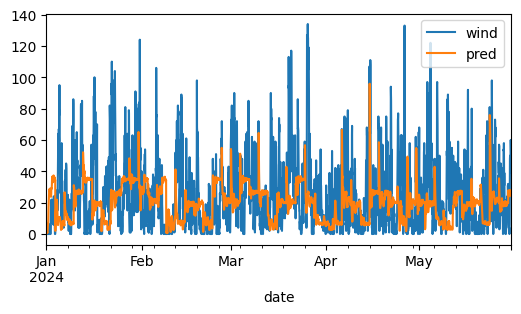

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 4.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 23.506696
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:0

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 568.0576964517752
RMSE: 23.833960989558054
MAE: 17.31640100676273
MAPE: 5144630386769215.0
Custom MAPE: 1.5810765725698694
Custom sMAPE: 0.414150118546208


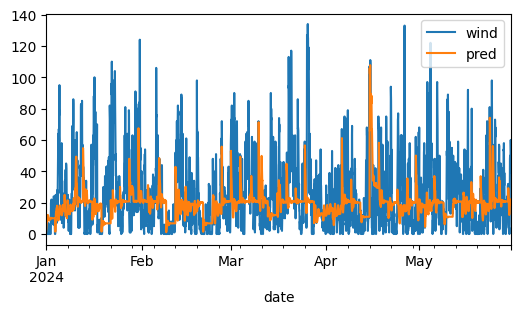

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 4.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 640.6502214553452
RMSE: 25.3110691488002
MAE: 17.949647319915577
MAPE: 3818361907799688.0
Custom MAPE: 1.3505530925258333
Custom sMAPE: 0.4658133061175762


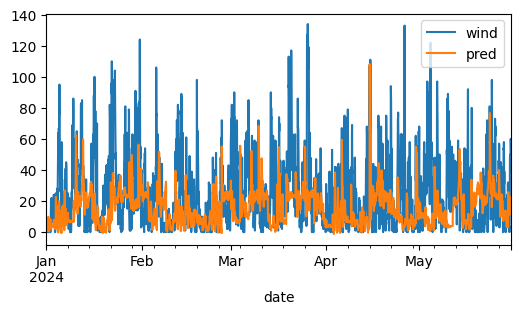

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

### 4.2. Recursive multi-step forecasting (with weather inputs)

#### 4.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          exog = df_wind[['wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                                          'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 327.28911062655266
RMSE: 18.09113348097771
MAE: 12.69689759867513
MAPE: 2488552666301584.5
Custom MAPE: 1.066673910477476
Custom sMAPE: 0.3404237090599419


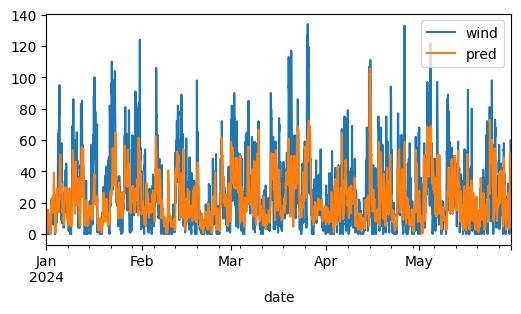

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 4.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          exog = df_wind[['wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                                          'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4855
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 33
[LightGBM] [Info] Start training from score 23.506696
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:0

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 302.1195650245478
RMSE: 17.38158695357095
MAE: 12.14012426388918
MAPE: 2234628593777263.5
Custom MAPE: 1.0209921889292766
Custom sMAPE: 0.32924874664930953


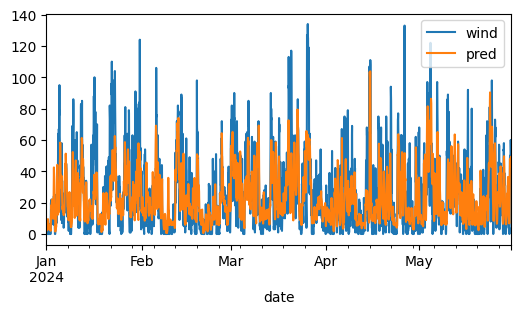

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 4.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          exog = df_wind[['wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                                          'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 320.0183385056577
RMSE: 17.889056389470568
MAE: 12.273222030107814
MAPE: 1453423749730323.8
Custom MAPE: 0.8928890135144261
Custom sMAPE: 0.344259701897612


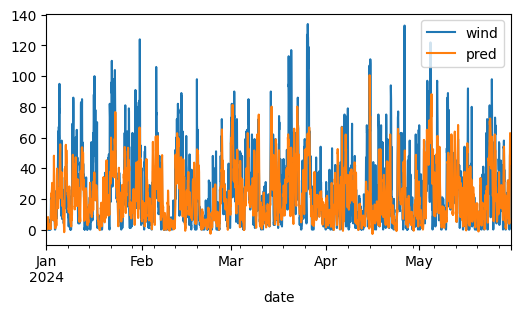

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 4.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1e-3, 1e2, log=True)

        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.000001, 0.5, log=True),
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        # "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        # 'max_depth': trial.suggest_int('max_depth', -1, 16),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          exog                  = df_wind[['wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                                                           'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          n_trials              = 200,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-07-09 11:51:17,397] Trial 0 finished with value: 14.979827214195097 and parameters: {'lags': 72, 'num_leaves': 176, 'max_depth': 7, 'learning_rate': 0.00370228692069884, 'n_estimators': 376, 'min_child_samples': 74, 'min_child_weight': 0.155905423533788, 'subsample': 0.15371010694861154, 'subsample_freq': 4, 'colsample_bytree': 0.7641958651588321, 'reg_alpha': 2.883592210117951e-07, 'reg_lambda': 2.53287670148807e-07}. Best is trial 0 with value: 14.979827214195097.
[I 2024-07-09 11:51:20,755] Trial 1 finished with value: 17.006885753588392 and parameters: {'lags': 12, 'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.000818564533066726, 'n_estimators': 329, 'min_child_samples': 65, 'min_child_weight': 0.0028875179969637577, 'subsample': 0.4903310554115754, 'subsample_freq': 4, 'colsample_bytree': 0.5443165878852756, 'reg_alpha': 2.550599806285011e-05, 'reg_lambda': 3.148399130467629e-06}. Best is trial 0 with value: 14.979827214195097.
[I 2024-07-09 11:51:26,266] Trial 2 fi

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 6, 'num_leaves': 101, 'max_depth': 16, 'learning_rate': 0.012476480865448518, 'n_estimators': 600, 'min_child_samples': 82, 'min_child_weight': 0.007233858860376053, 'subsample': 0.7467539888068863, 'subsample_freq': 1, 'colsample_bytree': 0.2951434860144695, 'reg_alpha': 3.8538863159424967e-07, 'reg_lambda': 9.117734961573712e-05}
11.385485653695062


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 101, max_depth = 16, learning_rate = 0.012476480865448518,
                                           n_estimators = 600, min_child_samples = 82, min_child_weight = 0.007233858860376053, subsample = 0.7467539888068863,
                                           subsample_freq = 1, colsample_bytree = 0.2951434860144695, reg_alpha = 3.8538863159424967e-07,
                                           reg_lambda = 9.117734961573712e-05, verbose = -1),
                 lags      = 6
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_wind['wind'],
                          exog = df_wind[['wind_speed_10m_ag', 'wind_direction_10m_ag', 'wind_gusts_10m_ag', 'wind_speed_10m_aa', 'wind_direction_10m_aa',
                                          'wind_gusts_10m_aa', 'wind_speed_10m_or', 'wind_direction_10m_or', 'wind_gusts_10m_or']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_wind_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 272.30544238643097
RMSE: 16.501679986790162
MAE: 11.385485653695062
MAPE: 1632362076679085.8
Custom MAPE: 0.9321898979004198
Custom sMAPE: 0.3158390147138486


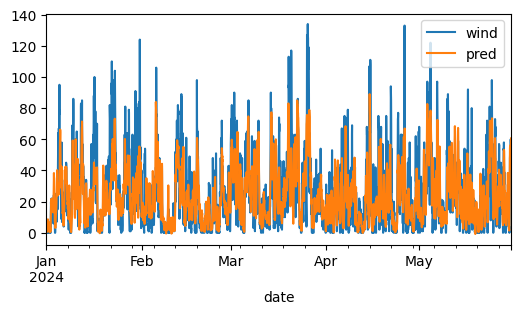

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_wind_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

## 5.Total Generation Model

In [ ]:
df_total = df_all.copy()
df_total = df_total[['date', 'apparent_temperature_nic', 'total']]

# Data preprocessing
# ==============================================================================
df_total['dow'] = df_total['date'].dt.dayofweek
df_total['mmonth'] = df_total['date'].dt.month
df_total['hhour'] = df_total['date'].dt.hour
df_total = df_total.set_index('date')
df_total = df_total.asfreq('H')
# data = data['y']
df_total = df_total.sort_index()
df_total

,apparent_temperature_nic,total,dow,mmonth,hhour
date,,,,,
2022-12-31 23:00:00+02:00,7.282764,517.0,5,12,23
2023-01-01 00:00:00+02:00,8.533049,496.0,6,1,0
2023-01-01 01:00:00+02:00,7.727057,476.0,6,1,1
2023-01-01 02:00:00+02:00,7.965912,451.0,6,1,2
2023-01-01 03:00:00+02:00,6.463960,413.0,6,1,3
...,...,...,...,...,...
2024-05-30 19:00:00+03:00,23.059320,621.0,3,5,19
2024-05-30 20:00:00+03:00,22.036884,618.0,3,5,20
2024-05-30 21:00:00+03:00,20.890568,620.0,3,5,21


In [ ]:
df_total_train = df_total[df_total.index < pd.Timestamp('2024-01-01', tz='Europe/Athens')]
df_total_test = df_total[df_total.index >= pd.Timestamp('2024-01-01', tz='Europe/Athens')]

In [ ]:
df_total_train.shape, df_total_test.shape

((8761, 5), (3623, 5))

### 5.1. Recursive multi-step forecasting (without weather inputs)

#### 5.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3314.4025947005243
RMSE: 57.57084847994273
MAE: 40.55332597295059
MAPE: 0.07094224121084954
Custom MAPE: 0.07094224121084954
Custom sMAPE: 0.03640274068893682


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


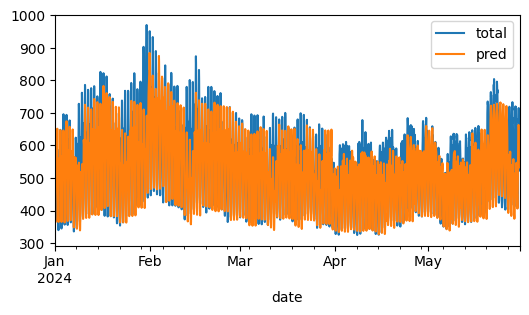

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 5.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 599.458739
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3128.357570266103
RMSE: 55.93172239674104
MAE: 39.72654003007409
MAPE: 0.07000554042960287
Custom MAPE: 0.07000554042960287
Custom sMAPE: 0.03578478441117863


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


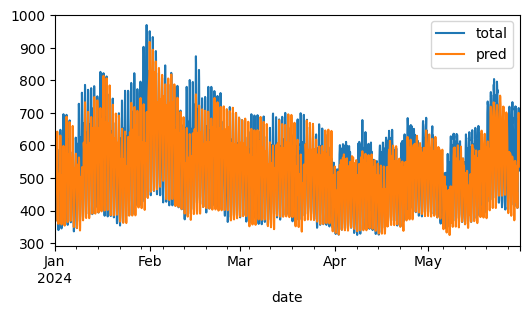

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 5.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 3230.276551672847
RMSE: 56.83552191783627
MAE: 40.34952540322624
MAPE: 0.070690954847464
Custom MAPE: 0.070690954847464
Custom sMAPE: 0.03610076944703844


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


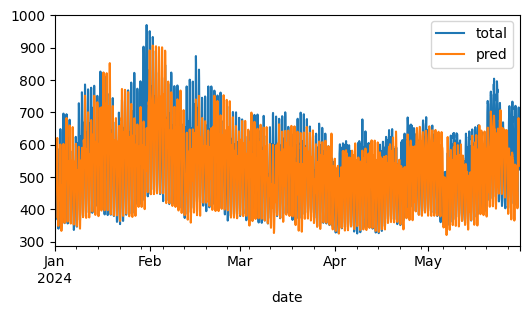

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

### 5.2. Recursive multi-step forecasting (with temp, dow, month, hour)

#### 5.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          exog                  = df_total[['apparent_temperature_nic', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1711.3536955837706
RMSE: 41.368510918133985
MAE: 27.70640077284019
MAPE: 0.048209854459321175
Custom MAPE: 0.048209854459321175
Custom sMAPE: 0.024592787016317296


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


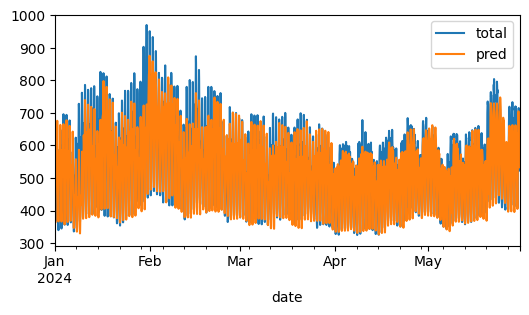

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 5.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          exog                  = df_total[['apparent_temperature_nic', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 28
[LightGBM] [Info] Start training from score 599.458739
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1284.054157826144
RMSE: 35.83370142514089
MAE: 24.89766804036643
MAPE: 0.04402162274761458
Custom MAPE: 0.04402162274761458
Custom sMAPE: 0.022226800898607204


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


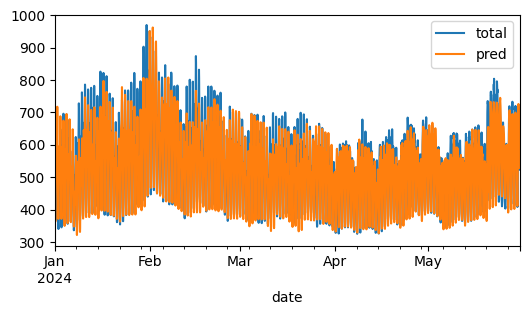

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 5.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          exog                  = df_total[['apparent_temperature_nic', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1422.7945601516212
RMSE: 37.71994910059691
MAE: 26.500868180033056
MAPE: 0.047183750434414015
Custom MAPE: 0.047183750434414015
Custom sMAPE: 0.024006918230594577


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


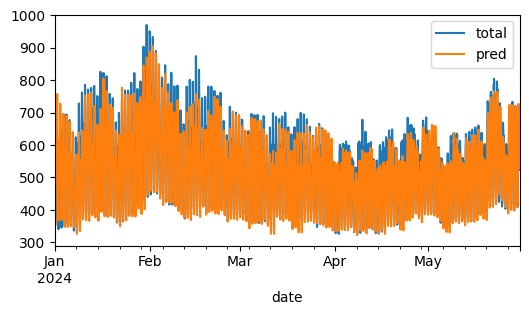

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

#### 5.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # 'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1e-3, 1e2, log=True)

        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.000001, 0.5, log=True),
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        # "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        # 'max_depth': trial.suggest_int('max_depth', -1, 16),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          exog                  = df_total[['apparent_temperature_nic', 'dow', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          n_trials              = 200,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-07-09 12:13:21,165] Trial 0 finished with value: 67.22722874573864 and parameters: {'lags': 72, 'num_leaves': 176, 'max_depth': 7, 'learning_rate': 0.00370228692069884, 'n_estimators': 376, 'min_child_samples': 74, 'min_child_weight': 0.155905423533788, 'subsample': 0.15371010694861154, 'subsample_freq': 4, 'colsample_bytree': 0.7641958651588321, 'reg_alpha': 2.883592210117951e-07, 'reg_lambda': 2.53287670148807e-07}. Best is trial 0 with value: 67.22722874573864.
[I 2024-07-09 12:13:25,088] Trial 1 finished with value: 97.67030253357902 and parameters: {'lags': 12, 'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.000818564533066726, 'n_estimators': 329, 'min_child_samples': 65, 'min_child_weight': 0.0028875179969637577, 'subsample': 0.4903310554115754, 'subsample_freq': 4, 'colsample_bytree': 0.5443165878852756, 'reg_alpha': 2.550599806285011e-05, 'reg_lambda': 3.148399130467629e-06}. Best is trial 0 with value: 67.22722874573864.
[I 2024-07-09 12:13:30,067] Trial 2 finish

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 48, 'num_leaves': 39, 'max_depth': 10, 'learning_rate': 0.023706695124685272, 'n_estimators': 740, 'min_child_samples': 8, 'min_child_weight': 12.753902308526325, 'subsample': 0.9635935647895763, 'subsample_freq': 0, 'colsample_bytree': 0.18995940073098536, 'reg_alpha': 0.0008969613756957391, 'reg_lambda': 0.01816131615338874}
21.384515068751227


In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 39, max_depth = 10, learning_rate =0.023706695124685272,
                                           n_estimators = 740, min_child_samples = 8, min_child_weight =  2.753902308526325, subsample = 0.9635935647895763,
                                           subsample_freq = 0, colsample_bytree = 0.18995940073098536, reg_alpha = 0.0008969613756957391,
                                           reg_lambda = 0.01816131615338874, verbose = -1),
                 lags      = 48
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_total['total'],
                          exog                  = df_total[['apparent_temperature_nic', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_total_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 939.8636733194951
RMSE: 30.657196109877614
MAE: 21.385121456673396
MAPE: 0.038723629740939666
Custom MAPE: 0.038723629740939666
Custom sMAPE: 0.019421341085208533


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


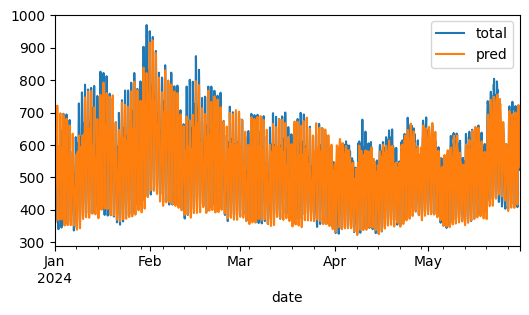

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_total_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

## 6.PV Generation Model

In [ ]:
df_all

,date,wind_speed_10m_ag,wind_direction_10m_ag,wind_gusts_10m_ag,wind_speed_10m_aa,wind_direction_10m_aa,wind_gusts_10m_aa,wind_speed_10m_or,wind_direction_10m_or,wind_gusts_10m_or,...,global_tilted_irradiance_nic,terrestrial_radiation_nic,total,wind,oil,gas,coal,biomass,pv,water
0,2022-12-31 23:00:00+02:00,11.384198,325.304779,22.680000,9.000000,306.869965,15.480000,10.799999,360.000000,20.880001,...,0.000000,0.000000,517.0,26.0,485.0,0.0,0.0,6.0,0.0,0.0
1,2023-01-01 00:00:00+02:00,11.792404,328.736328,23.400000,9.957108,319.398773,17.280001,11.966953,6.911131,23.400000,...,0.000000,0.000000,496.0,34.0,455.0,0.0,0.0,6.0,0.0,0.0
2,2023-01-01 01:00:00+02:00,12.413477,330.461304,25.559999,9.504272,322.695953,18.000000,11.013882,11.309896,23.759998,...,0.000000,0.000000,476.0,36.0,434.0,0.0,0.0,6.0,0.0,0.0
3,2023-01-01 02:00:00+02:00,13.089354,328.495789,24.840000,9.673221,315.000092,16.559999,7.993298,7.765082,21.599998,...,0.000000,0.000000,451.0,36.0,408.0,0.0,0.0,6.0,0.0,0.0
4,2023-01-01 03:00:00+02:00,12.240000,331.927612,26.280001,9.178235,318.179901,17.280001,9.779817,6.340100,18.719999,...,0.000000,0.000000,413.0,33.0,374.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12379,2024-05-30 19:00:00+03:00,2.968636,345.963715,13.320000,7.421590,337.166290,15.840000,16.179985,290.854523,37.799999,...,87.539574,347.788971,621.0,48.0,530.0,0.0,0.0,6.0,36.0,0.0
12380,2024-05-30 20:00:00+03:00,10.661107,348.310669,19.440001,14.277983,326.309906,25.559999,13.849477,297.897186,34.560001,...,21.659176,97.454674,618.0,60.0,549.0,0.0,0.0,6.0,3.0,0.0
12381,2024-05-30 21:00:00+03:00,12.558790,332.700500,23.759998,17.317459,316.684631,32.399998,11.753876,319.969788,28.799999,...,0.000000,0.000000,620.0,53.0,558.0,0.0,0.0,6.0,3.0,0.0
12382,2024-05-30 22:00:00+03:00,11.753876,319.969788,23.759998,17.610588,310.855286,33.119999,10.630672,331.699341,24.480000,...,0.000000,0.000000,573.0,52.0,512.0,0.0,0.0,6.0,3.0,0.0


In [ ]:
df_pv = df_all.copy()
df_pv = df_pv[['date', 'apparent_temperature_nic', 'shortwave_radiation_nic', 'direct_radiation_nic',
               'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic', 'pv']]

# Data preprocessing
# ==============================================================================
# df_pv['dow'] = df_pv['date'].dt.dayofweek
df_pv['mmonth'] = df_pv['date'].dt.month
df_pv['hhour'] = df_pv['date'].dt.hour
df_pv = df_pv.set_index('date')
df_pv = df_pv.asfreq('H')
# data = data['y']
df_pv = df_pv.sort_index()
df_pv

,apparent_temperature_nic,shortwave_radiation_nic,direct_radiation_nic,diffuse_radiation_nic,direct_normal_irradiance_nic,global_tilted_irradiance_nic,terrestrial_radiation_nic,pv,mmonth,hhour
date,,,,,,,,,,
2022-12-31 23:00:00+02:00,7.282764,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,12,23
2023-01-01 00:00:00+02:00,8.533049,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1,0
2023-01-01 01:00:00+02:00,7.727057,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1,1
2023-01-01 02:00:00+02:00,7.965912,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1,2
2023-01-01 03:00:00+02:00,6.463960,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+03:00,23.059320,167.0,84.0,83.0,321.463501,87.539574,347.788971,36.0,5,19
2024-05-30 20:00:00+03:00,22.036884,32.0,10.0,22.0,85.195602,21.659176,97.454674,3.0,5,20
2024-05-30 21:00:00+03:00,20.890568,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,5,21


In [ ]:
df_pv_train = df_pv[df_pv.index < pd.Timestamp('2024-01-01', tz='Europe/Athens')]
df_pv_test = df_pv[df_pv.index >= pd.Timestamp('2024-01-01', tz='Europe/Athens')]

In [ ]:
df_pv_train.shape, df_pv_test.shape

((8761, 10), (3623, 10))

### 6.1. Recursive multi-step forecasting (without weather inputs)

#### 6.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1633.8350375655534
RMSE: 40.42072534685088
MAE: 20.68359094672923
MAPE: 12542456594029.56
Custom MAPE: 0.2186810470806549
Custom sMAPE: 0.09231964324157604


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


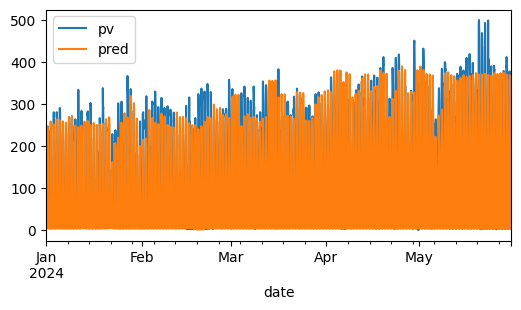

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 24
[LightGBM] [Info] Start training from score 92.975506
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1739.7303994274987
RMSE: 41.710075514526444
MAE: 21.001744664807447
MAPE: 9934383860921.898
Custom MAPE: 0.27209390546857226
Custom sMAPE: 0.09584089354020889


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


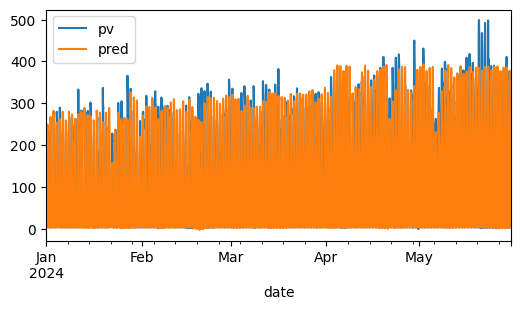

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1906.110693483411
RMSE: 43.65902762869795
MAE: 23.117673087388784
MAPE: 8788207851087.897
Custom MAPE: 0.33615705749676944
Custom sMAPE: 0.1474869072559926


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


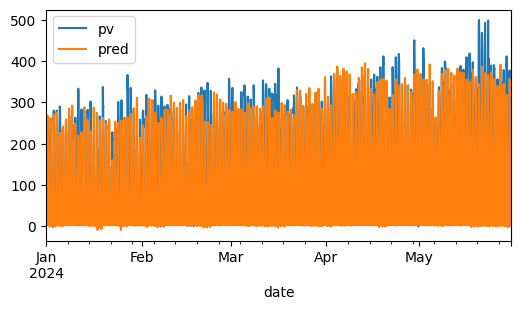

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 6.1.4.Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # 'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1e-3, 1e2, log=True)
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          # exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          n_trials              = 200,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_NoExog_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-07-09 12:40:07,093] Trial 0 finished with value: 56.112066881862766 and parameters: {'lags': 72, 'num_leaves': 176, 'max_depth': 7, 'learning_rate': 0.00370228692069884, 'n_estimators': 376, 'min_child_samples': 74, 'min_child_weight': 0.155905423533788, 'subsample': 0.15371010694861154, 'subsample_freq': 4, 'colsample_bytree': 0.7641958651588321, 'reg_alpha': 2.883592210117951e-07, 'reg_lambda': 2.53287670148807e-07}. Best is trial 0 with value: 56.112066881862766.
[I 2024-07-09 12:40:10,317] Trial 1 finished with value: 109.51531820050967 and parameters: {'lags': 12, 'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.000818564533066726, 'n_estimators': 329, 'min_child_samples': 65, 'min_child_weight': 0.0028875179969637577, 'subsample': 0.4903310554115754, 'subsample_freq': 4, 'colsample_bytree': 0.5443165878852756, 'reg_alpha': 2.550599806285011e-05, 'reg_lambda': 3.148399130467629e-06}. Best is trial 0 with value: 56.112066881862766.
[I 2024-07-09 12:40:14,158] Trial 2 fi

In [ ]:
# # Bayesian search hyperparameters and lags with Optuna
# # ==============================================================================
# forecaster = ForecasterAutoreg(
#                  regressor = RandomForestRegressor(random_state=123),
#                  lags      = 24 # Placeholder, the value will be overwritten
#              )

# # Search space
# def search_space(trial):
#     search_space  = {
#         'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
#         'n_estimators'     : trial.suggest_int('n_estimators', 10, 1000),
#         'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 6),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'ccp_alpha'        : trial.suggest_float('ccp_alpha', 0., 1.),
#         'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
#     }

#     return search_space

# results, best_trial = bayesian_search_forecaster(
#                           forecaster            = forecaster,
#                           y                     = df_pv['pv'],
#                           # exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour']],
#                           search_space          = search_space,
#                           steps                 = 24*3,
#                           metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
#                           refit                 = False,
#                           initial_train_size    = len(df_pv_train),
#                           fixed_train_size      = True,
#                           n_trials              = 200,
#                           random_state          = 123,
#                           return_best           = True,
#                           n_jobs                = 'auto',
#                           verbose               = False,
#                           show_progress         = True,
#                           engine                = 'optuna',
#                           kwargs_create_study   = {},
#                           kwargs_study_optimize = {},
#                           output_file           = google_drive_path + "results_pv_recursive_optuna_rf.txt"
#                       )

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-07-08 08:34:59,182] Trial 0 finished with value: 1490.0354759222405 and parameters: {'lags': 72, 'n_estimators': 688, 'min_samples_leaf': 4, 'min_samples_split': 5, 'ccp_alpha': 0.3431780161508694, 'max_features': 'log2'}. Best is trial 0 with value: 1490.0354759222405.
[I 2024-07-08 08:37:05,318] Trial 1 finished with value: 39262.2647643575 and parameters: {'lags': 6, 'n_estimators': 638, 'min_samples_leaf': 6, 'min_samples_split': 8, 'ccp_alpha': 0.6110235106775829, 'max_features': 'log2'}. Best is trial 0 with value: 1490.0354759222405.
[I 2024-07-08 08:38:47,949] Trial 2 finished with value: 10072.433025411568 and parameters: {'lags': 12, 'n_estimators': 499, 'min_samples_leaf': 4, 'min_samples_split': 4, 'ccp_alpha': 0.4263513069628082, 'max_features': 'sqrt'}. Best is trial 0 with value: 1490.0354759222405.
[I 2024-07-08 08:40:33,924] Trial 3 finished with value: 1519.6604384667694 and parameters: {'lags': 48, 'n_estimators': 488, 'min_samples_leaf': 6, 'min_samples_spli

KeyboardInterrupt: 

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 72, 'num_leaves': 139, 'max_depth': 6, 'learning_rate': 0.027394680280621853, 'n_estimators': 411, 'min_child_samples': 93, 'min_child_weight': 0.005659069928213818, 'subsample': 0.9613488198429598, 'subsample_freq': 10, 'colsample_bytree': 0.21089251015661575, 'reg_alpha': 3.559063973221273e-07, 'reg_lambda': 0.11846819374114309}
18.47333512923093


In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 139, max_depth = 6, learning_rate = 0.027394680280621853,
                                           n_estimators = 411, min_child_samples = 93, min_child_weight =  0.005659069928213818, subsample = 0.9613488198429598,
                                           subsample_freq = 10, colsample_bytree = 0.21089251015661575, reg_alpha = 3.559063973221273e-07,
                                           reg_lambda = 0.11846819374114309, verbose = -1),
                 lags      = 72
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          # exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1454.5056628521256
RMSE: 38.13798189275523
MAE: 18.47333512923093
MAPE: 7770513851808.031
Custom MAPE: 0.2090447331884274
Custom sMAPE: 0.08513786590378224


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


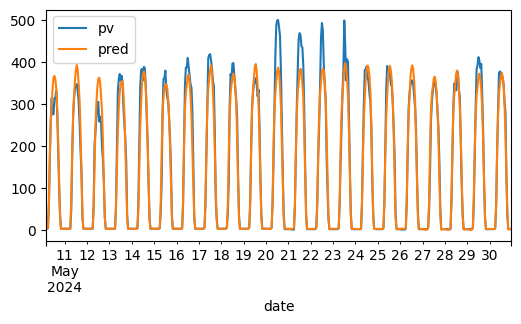

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show()

### 6.2. Recursive multi-step forecasting (with temp, month, hour)

#### 6.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour', 'shortwave_radiation_nic', 'direct_radiation_nic',
                                                         'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1732.5234852884353
RMSE: 41.6235928925944
MAE: 22.16873861440795
MAPE: 7669668700214.377
Custom MAPE: 0.2018504988412468
Custom sMAPE: 0.1081461699666979


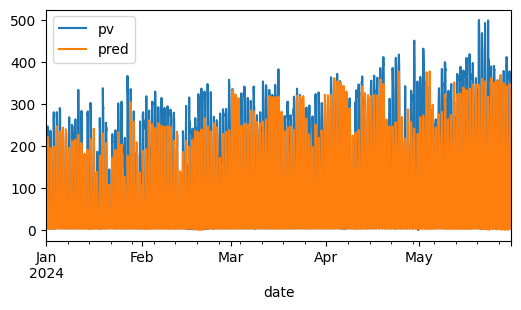

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour', 'shortwave_radiation_nic', 'direct_radiation_nic',
                                                         'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7942
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 33
[LightGBM] [Info] Start training from score 92.975506
Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1920.9270631048746
RMSE: 43.828381935737426
MAE: 23.99175282852845
MAPE: 9763532115527.785
Custom MAPE: 0.2620717205291443
Custom sMAPE: 0.12144222615397071


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


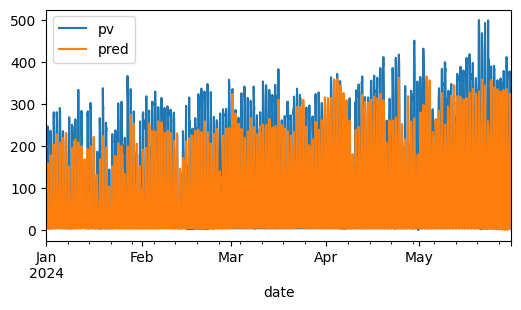

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour', 'shortwave_radiation_nic', 'direct_radiation_nic',
                                                         'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1990.5871353734108
RMSE: 44.6159964068204
MAE: 24.497286405006133
MAPE: 10033538538274.465
Custom MAPE: 0.3375647744941551
Custom sMAPE: 0.21076177050438322


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


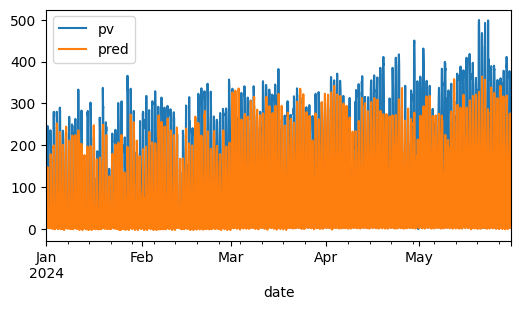

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.4. Optuna (LightGBM)

In [ ]:
# # Bayesian search hyperparameters and lags with Optuna
# # ==============================================================================
# forecaster = ForecasterAutoreg(
#                  regressor = LGBMRegressor(random_state=123, verbose = -1),
#                  lags      = 24 # Placeholder, the value will be overwritten
#              )

# # Search space
# def search_space(trial):
#     search_space  = {
#         'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
#         # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
#         'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
#         'max_depth'        : trial.suggest_int('max_depth', -1, 16),
#         'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
#         'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
#         'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
#         'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
#         'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1e-3, 1e2, log=True)

#         # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         # 'learning_rate': trial.suggest_float('learning_rate', 0.000001, 0.5, log=True),
#         # 'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         # "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
#         # 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
#         # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
#         # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
#         # 'max_depth': trial.suggest_int('max_depth', -1, 16),
#     }

#     return search_space

# results, best_trial = bayesian_search_forecaster(
#                           forecaster            = forecaster,
#                           y                     = df_pv['pv'],
#                           exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour']],
#                           search_space          = search_space,
#                           steps                 = 24*3,
#                           metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
#                           refit                 = False,
#                           initial_train_size    = len(df_pv_train),
#                           fixed_train_size      = True,
#                           n_trials              = 200,
#                           random_state          = 123,
#                           return_best           = True,
#                           n_jobs                = 'auto',
#                           verbose               = False,
#                           show_progress         = True,
#                           engine                = 'optuna',
#                           kwargs_create_study   = {},
#                           kwargs_study_optimize = {},
#                           output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
#                       )

In [ ]:
# # Print the best hyperparameters
# print(best_trial.params)
# print(best_trial.value)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
        # 'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # 'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1e-3, 1e2, log=True)

        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.000001, 0.5, log=True),
        # 'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        # "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        # 'max_depth': trial.suggest_int('max_depth', -1, 16),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour', 'shortwave_radiation_nic', 'direct_radiation_nic',
                                                         'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          n_trials              = 200,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-07-10 08:25:54,159] Trial 0 finished with value: 51.40735310270985 and parameters: {'lags': 72, 'num_leaves': 176, 'max_depth': 7, 'learning_rate': 0.00370228692069884, 'n_estimators': 376, 'min_child_samples': 74, 'min_child_weight': 0.155905423533788, 'subsample': 0.15371010694861154, 'subsample_freq': 4, 'colsample_bytree': 0.7641958651588321, 'reg_alpha': 2.883592210117951e-07, 'reg_lambda': 2.53287670148807e-07}. Best is trial 0 with value: 51.40735310270985.
[I 2024-07-10 08:25:57,493] Trial 1 finished with value: 92.80990475157567 and parameters: {'lags': 12, 'num_leaves': 84, 'max_depth': 5, 'learning_rate': 0.000818564533066726, 'n_estimators': 329, 'min_child_samples': 65, 'min_child_weight': 0.0028875179969637577, 'subsample': 0.4903310554115754, 'subsample_freq': 4, 'colsample_bytree': 0.5443165878852756, 'reg_alpha': 2.550599806285011e-05, 'reg_lambda': 3.148399130467629e-06}. Best is trial 0 with value: 51.40735310270985.
[I 2024-07-10 08:26:02,279] Trial 2 finish

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'num_leaves': 118, 'max_depth': 9, 'learning_rate': 0.038445734199648564, 'n_estimators': 899, 'min_child_samples': 59, 'min_child_weight': 0.0010021147380469715, 'subsample': 0.728646716191738, 'subsample_freq': 9, 'colsample_bytree': 0.21554674354322512, 'reg_alpha': 6.574357949512815e-05, 'reg_lambda': 0.021863764615261887}
17.6895390168738


In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 118, max_depth = 9, learning_rate = 0.038445734199648564,
                                           n_estimators = 899, min_child_samples = 59, min_child_weight = 0.0010021147380469715, subsample = 0.728646716191738,
                                           subsample_freq = 9, colsample_bytree = 0.21554674354322512, reg_alpha = 6.574357949512815e-05,
                                           reg_lambda = 0.021863764615261887, verbose = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour', 'shortwave_radiation_nic', 'direct_radiation_nic',
                                                         'diffuse_radiation_nic', 'direct_normal_irradiance_nic', 'global_tilted_irradiance_nic', 'terrestrial_radiation_nic']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1116.476932967475
RMSE: 33.41372372196004
MAE: 17.6895390168738
MAPE: 9627781666040.168
Custom MAPE: 0.22847380170295656
Custom sMAPE: 0.12235343528327884


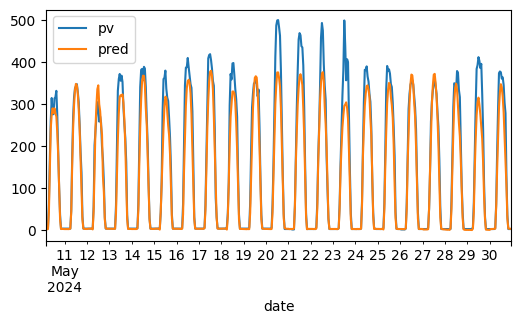

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 72, max_depth = 15, learning_rate = 0.015126962837893726,
                                           n_estimators = 357, min_child_samples = 71, min_child_weight =  0.00391995830731753, subsample = 0.40262080685288515,
                                           subsample_freq = 1, colsample_bytree = 0.23960648639936646, reg_alpha = 8.257993465373733e-07,
                                           reg_lambda = 9.173293661226691e-07, scale_pos_weight = 0.19379808286869896, verbose = -1),
                 lags      = 72
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_pv['pv'],
                          exog                  = df_pv[['apparent_temperature_nic', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                          initial_train_size    = len(df_pv_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8761
Number of observations used for backtesting: 3623
    Number of folds: 51
    Number of steps per fold: 72
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 23 observations.

Fold: 0
    Training:   2022-12-31 23:00:00+02:00 -- 2023-12-31 23:00:00+02:00  (n=8761)
    Validation: 2024-01-01 00:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=72)
Fold: 1
    Training:   2023-01-03 23:00:00+02:00 -- 2024-01-03 23:00:00+02:00  (n=8761)
    Validation: 2024-01-04 00:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=72)
Fold: 2
    Training:   2023-01-06 23:00:00+02:00 -- 2024-01-06 23:00:00+02:00  (n=8761)
    Validation: 2024-01-07 00:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=72)
Fold: 3
    Training:   2023-01-09 23:00:00+02:00 -- 2024-01-09 23:00:00+02:00  (n=8761)
    Validation: 2024-01-10 00:00:00+02:00 -- 2

/usr/local/lib/python3.10/dist-packages/skforecast/model_selection/model_selection.py:474: LongTrainingWarning: The forecaster will be fit 51 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))

MSE: 1447.2858252892106
RMSE: 38.043209976147
MAE: 19.649973260930185
MAPE: 9324475353256.453


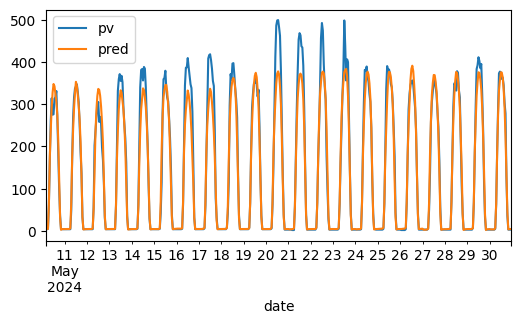

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_pv_test['pv'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
# # Search space
# def search_space(trial):
#     search_space  = {
#         'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24, 48, 72]),
#         'n_estimators'     : trial.suggest_int('n_estimators', 10, 1000),
#         'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 6),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'ccp_alpha'        : trial.suggest_float('ccp_alpha', 0., 1.),
#         'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
#     }

#     return search_space

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-07-06 16:56:52,283] Trial 0 finished with value: 588.0687817123683 and parameters: {'lags': 72, 'n_estimators': 688, 'min_samples_leaf': 4, 'min_samples_split': 5, 'ccp_alpha': 0.3431780161508694, 'max_features': 'log2'}. Best is trial 0 with value: 588.0687817123683.
[I 2024-07-06 16:58:59,800] Trial 1 finished with value: 549.9943149909836 and parameters: {'lags': 6, 'n_estimators': 638, 'min_samples_leaf': 6, 'min_samples_split': 8, 'ccp_alpha': 0.6110235106775829, 'max_features': 'log2'}. Best is trial 1 with value: 549.9943149909836.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_estimators': 638, 'min_samples_leaf': 6, 'min_samples_split': 8, 'ccp_alpha': 0.6110235106775829, 'max_features': 'log2'}
  Backtesting metric: 549.9943149909836

